In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
keep_prob = 0.8
learning_rate = 0.001

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([8, 3, 32, 32])


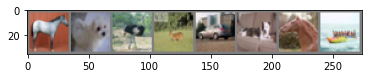

horse dog   bird  deer  car   dog   horse ship 


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)


# show images
imshow(torchvision.utils.make_grid(images[0:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [15]:
# define a function to calulate the output size of a convolutional layer
# input_size: the size of the input
# kernel_size: the size of the kernel
# stride: the stride of the convolution
# padding: the padding of the convolution
# dilation: the dilation of the convolution
# groups: the number of groups of the convolution

def conv_output_size(input_size, kernel_size, stride=1, padding=0, dilation=1):
    return int((input_size + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1)


input_size = 6
kernel_size = 3

print(conv_output_size(input_size, kernel_size))


4


In [16]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 120, 3)
        
        
        self.fc1 = nn.Linear(1920, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # use softmax to normalize the output
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
from torchinfo import summary

summary(net, (batch_size,3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [8, 6, 30, 30]            168
├─MaxPool2d: 1-2                         [8, 6, 15, 15]            --
├─Conv2d: 1-3                            [8, 16, 13, 13]           880
├─MaxPool2d: 1-4                         [8, 16, 6, 6]             --
├─Conv2d: 1-5                            [8, 120, 4, 4]            17,400
├─Linear: 1-6                            [8, 120]                  230,520
├─Linear: 1-7                            [8, 84]                   10,164
├─Linear: 1-8                            [8, 10]                   850
Total params: 259,982
Trainable params: 259,982
Non-trainable params: 0
Total mult-adds (M): 6.56
Input size (MB): 0.10
Forward/backward pass size (MB): 0.66
Params size (MB): 1.04
Estimated Total Size (MB): 1.79

In [18]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(1-keep_prob)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(1-keep_prob),
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2,padding=1),
            torch.nn.Dropout(1-keep_prob),
        )
        self.fc1 = torch.nn.Linear(3200, 160)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(1-keep_prob)
        )
        self.fc2 = torch.nn.Linear(160, 80)
        self.layer5 = torch.nn.Sequential(
            self.fc2,
            torch.nn.ReLU(),
            torch.nn.Dropout(1-keep_prob)
        )
        self.fc3 = torch.nn.Linear(80, 10)
        self.layer6 = torch.nn.Sequential(
            self.fc3,
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, 1)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

net2 = Net2()
net2.to(device)

summary(net2, (batch_size,3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     --                        --
├─Sequential: 1-1                        [8, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [8, 32, 32, 32]           896
│    └─ReLU: 2-2                         [8, 32, 32, 32]           --
│    └─MaxPool2d: 2-3                    [8, 32, 16, 16]           --
│    └─Dropout: 2-4                      [8, 32, 16, 16]           --
├─Sequential: 1-2                        [8, 64, 8, 8]             --
│    └─Conv2d: 2-5                       [8, 64, 16, 16]           18,496
│    └─ReLU: 2-6                         [8, 64, 16, 16]           --
│    └─MaxPool2d: 2-7                    [8, 64, 8, 8]             --
│    └─Dropout: 2-8                      [8, 64, 8, 8]             --
├─Sequential: 1-3                        [8, 128, 5, 5]            --
│    └─Conv2d: 2-9                       [8, 128, 8, 8]            73,856
│    └

In [19]:
class BasicBlock(nn.Module):
	def __init__(self, channel_num):
		super(BasicBlock, self).__init__()
		self.conv_block1 = nn.Sequential(
			nn.Conv2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
			nn.ReLU(),
		) 
		self.conv_block2 = nn.Sequential(
			nn.Conv2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
		)
		self.relu = nn.ReLU()
	
	def forward(self, x):
		residual = x
		x = self.conv_block1(x)
		x = self.conv_block2(x)
		x = x + residual
		out = self.relu(x)
		return out

class Net3(nn.Module):
	def __init__(self):
		super(Net3, self).__init__()
		channel_num = 16
		
		self.init_block = nn.Sequential(
			nn.Conv2d(3, channel_num, 1),
			nn.ReLU(),
		) 
		self.basic_blocks = nn.ModuleList([BasicBlock(channel_num) for i in range(5)])

		self.final_block = nn.Sequential(
			nn.Conv2d(channel_num, 3, 1),
			nn.Sigmoid(),
		) 
		self.fc1 = torch.nn.Linear(3072, 160)
		self.layer1 = torch.nn.Sequential(
			self.fc1,
			nn.ReLU(),
		)
		self.fc2 = torch.nn.Linear(160, 80)
		self.layer2 = torch.nn.Sequential(
			self.fc2,
			nn.ReLU()
		)
		self.fc3 = torch.nn.Linear(80, 10)
		self.layer3 = torch.nn.Sequential(
			self.fc3,
		)


	def forward(self, x):
	
		x = self.init_block(x)
		for i, _ in enumerate(self.basic_blocks):
			x = self.basic_blocks[i](x)
		
		x = self.final_block(x)
		x = torch.flatten(x, 1)
		x = self.layer1(x)
		x = self.layer2(x)
		out = self.layer3(x)
		
		return out

net3 = Net3()
net3.to(device)

summary(net3, (batch_size,3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net3                                     --                        --
├─ModuleList: 1-1                        --                        --
├─Sequential: 1-2                        [8, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [8, 16, 32, 32]           64
│    └─ReLU: 2-2                         [8, 16, 32, 32]           --
├─ModuleList: 1-1                        --                        --
│    └─BasicBlock: 2-3                   [8, 16, 32, 32]           --
│    │    └─Sequential: 3-1              [8, 16, 32, 32]           2,352
│    │    └─Sequential: 3-2              [8, 16, 32, 32]           2,352
│    │    └─ReLU: 3-3                    [8, 16, 32, 32]           --
│    └─BasicBlock: 2-4                   [8, 16, 32, 32]           --
│    │    └─Sequential: 3-4              [8, 16, 32, 32]           2,352
│    │    └─Sequential: 3-5              [8, 16, 32, 32]           2,352
│  

In [31]:
import torch.optim as optim

def run(net, trainloader, epoch_num=2, mini_batch_size=2000):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Adam = adaptive momentum optimizer
    # SGD = stochastic gradient descent optimizer
    for epoch in range(epoch_num):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
        
            print(labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            print(outputs)
            # print(labels)
            # print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % mini_batch_size == mini_batch_size-1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / mini_batch_size:.3f}')
                running_loss = 0.0

    print('Finished Training')


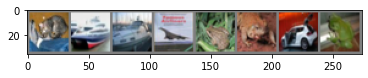

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 


In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[0:8]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [22]:
# since we're not training, we don't need to calculate the gradients for our outputs
# test
def test(net,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [32]:
# run and test for each net 
run(net, trainloader)
test(net, testloader)

tensor([2, 3, 9, 4, 5, 6, 6, 4], device='cuda:0')
tensor([[ -0.1220,  -2.2434,   0.4508,   0.2667,  -1.6217,  -0.4893,  -0.5157,
          -1.4927,  -2.2443,  -2.0590],
        [ -2.8784,  -3.2235,  -1.4432,   1.5236,  -0.9708,   1.9812,  -2.5367,
          -0.2431,  -2.9187,  -3.6539],
        [ -1.9334,  -0.4987,  -1.3003,  -0.2058,  -2.6207,  -0.8151,  -1.2256,
          -1.7437,  -4.1524,   0.7220],
        [ -1.8084,  -1.8072,  -1.0079,  -0.3741,  -1.4256,  -0.8007,  -2.8373,
          -0.8826,  -1.4007,   0.5886],
        [ -1.1023,  -3.0705,  -0.0142,   0.4692,  -1.3357,   1.8774,  -2.5329,
           0.0429,  -2.5308,  -2.8444],
        [ -1.3773,  -0.7099,  -0.5449,   0.7848,  -0.7732,  -0.4681,  -0.7376,
          -1.5837,  -0.6511,  -1.5272],
        [ -7.0942,  -6.0622,  -0.5793,  -3.4680,  -2.9115,  -6.4373,   6.3662,
         -10.8626, -11.7468,  -8.9846],
        [ -0.7840,  -5.0421,   0.0699,  -0.7100,   1.2241,  -0.4256,  -3.8063,
          -0.6681,  -3.8515,  -4.7752]

KeyboardInterrupt: 

In [24]:
# run(net2, trainloader)
# test(net2, testloader)

In [25]:
# run(net3,trainloader)
# test(net3, testloader)

In [26]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

# r